In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from collections import defaultdict

# NOTES:
# Consider the recall of a random classifier -> Should be 0.5 (Correctly guesses half the time and incorrectly guesses half the time -> (True Positive = Half of 1 class, False Negative Half of 1 class))
# Consider precision of random classifier -> Half of 1 Class / Half of all data = Number of 1 / Number of all data
# Consider F1 score of random classifier

In [2]:
df = pd.read_csv("./kieranFeatures_1-30_14-Nov-2024_rawSA.csv").replace([np.inf, -np.inf], np.nan).interpolate() # Perform linear interpolation on all non-valid numbers

df["Lv_1_Lo"] = (df["SA1"] < 5).astype(int)
df["Lv_2_Lo"] = (df["SA2"] < 5).astype(int)
df["Lv_3_Lo"] = (df["SA3"] < 5).astype(int)
df["Tot_Lo"] = (df["SAtotal"] < 15).astype(int)

ids = df.iloc[:, 0]
trial_nums = df.iloc[:, 1]
predictors_df = df.iloc[:, 2:df.shape[1] - 8]
outcomes_df = df.iloc[:, df.shape[1] - 8:]
outcomes_df_shuffled = outcomes_df.copy()

# Shuffle Labels
outcomes_df_shuffled["Lv_1_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_1_Lo"])
outcomes_df_shuffled["Lv_2_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_2_Lo"])
outcomes_df_shuffled["Lv_3_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_3_Lo"])
outcomes_df_shuffled["Tot_Lo"] = np.random.permutation(outcomes_df_shuffled["Tot_Lo"])

# Free Memory
del df

In [3]:
f1_scores = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

accuracy_scores = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

CV_models = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

modified_LASSO_features = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

f1_scores_shuffled = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

accuracy_scores_shuffled = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

CV_models_shuffled = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

modified_LASSO_features_shuffled = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

In [4]:
def evaluate_models(pred_df, out_df, ids, trial_nums):
    f1_scores = defaultdict(list)
    accuracy_scores = defaultdict(list)
    models = defaultdict(list)
    modified_LASSO_selected_features = []

    # Obtain 5 tes t folds stratifying by participant ID
    skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    for i, (CV_idx, test_idx) in enumerate(skf.split(pred_df, ids)):
        # Train-Test Split for the Fold
        ids_CV = ids.iloc[CV_idx].values
        # ids_test = ids.iloc[test_idx].values
        # trial_nums_CV = ids.iloc[CV_idx].values
        # trial_nums_test = ids.iloc[test_idx].values
        pred_CV = pred_df.iloc[CV_idx, :].values
        pred_test = pred_df.iloc[test_idx, :].values
        out_CV = out_df.iloc[CV_idx].values
        out_test = out_df.iloc[test_idx].values

        # Standardize data for each test fold
        scaler = StandardScaler()
        pred_CV = scaler.fit_transform(pred_CV)
        pred_test = scaler.transform(pred_test)

        # Setup Cross Validation Object
        CV_skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
        
        # Initialize Models to Train
        no_penalty_model = LogisticRegression(
            fit_intercept = False,
            solver = "saga",
            n_jobs = -1,
            max_iter = 20000,
            class_weight = "balanced",
            penalty = None
        )

        Ridge_model = LogisticRegressionCV(
            Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
            cv = CV_skf.split(pred_CV, ids_CV), 
            fit_intercept = False,
            class_weight = "balanced", 
            solver = "saga", 
            n_jobs = -1, 
            max_iter = 20000, 
            scoring = "f1", 
            refit = True
        )

        LASSO_model = LogisticRegressionCV(
            Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
            cv = CV_skf.split(pred_CV, ids_CV), 
            fit_intercept = False,
            class_weight = "balanced",
            penalty = "l1", 
            solver = "saga", 
            n_jobs = -1, 
            max_iter = 20000, 
            scoring = "f1", 
            refit = True
        )

        modified_LASSO_model = LogisticRegression(
            fit_intercept = False,
            solver = "saga",
            n_jobs = -1,
            max_iter = 20000,
            class_weight = "balanced",
            penalty = None
        )

        # Fit Models
        no_penalty_model.fit(pred_CV, out_CV)
        Ridge_model.fit(pred_CV, out_CV)
        LASSO_model.fit(pred_CV, out_CV)

        # Obtain and fit "Modified LASSO" Model
        selector = SelectFromModel(LASSO_model, threshold = "mean", prefit = True)
        selected_features = selector.get_support()
        pred_CV_selected = pred_CV[:, selected_features]
        pred_test_selected = pred_test[:, selected_features]
        modified_LASSO_model.fit(pred_CV_selected, out_CV)

        # Append F1 Scores
        f1_scores["No Penalty"].append(f1_score(out_test, no_penalty_model.predict(pred_test)))
        f1_scores["Ridge"].append(f1_score(out_test, Ridge_model.predict(pred_test)))
        f1_scores["LASSO"].append(f1_score(out_test, LASSO_model.predict(pred_test)))   
        f1_scores["Modified LASSO"].append(f1_score(out_test, modified_LASSO_model.predict(pred_test_selected)))

        # Append accuracy Scores
        accuracy_scores["No Penalty"].append(balanced_accuracy_score(out_test, no_penalty_model.predict(pred_test)))
        accuracy_scores["Ridge"].append(balanced_accuracy_score(out_test, Ridge_model.predict(pred_test)))
        accuracy_scores["LASSO"].append(balanced_accuracy_score(out_test, LASSO_model.predict(pred_test)))
        accuracy_scores["Modified LASSO"].append(balanced_accuracy_score(out_test, modified_LASSO_model.predict(pred_test_selected)))

        # Remove generator from models to allow pickling
        Ridge_model.set_params(cv = None)
        LASSO_model.set_params(cv = None)

        # Add Models and Scores to Dictionaries
        models["No Penalty"].append(no_penalty_model)
        models["Ridge"].append(Ridge_model)
        models["LASSO"].append(LASSO_model)
        models["Modified LASSO"].append(modified_LASSO_model)

        # Store selected features for relaxed LASSO
        modified_LASSO_selected_features.append(selected_features)

        # Completion Message
        print(f"Test Fold {i + 1} Completed")

    return f1_scores, accuracy_scores, models, modified_LASSO_selected_features

In [7]:
# 94 mins
outcome_var = "Lv_1_Lo"
f1_scores[outcome_var], accuracy_scores[outcome_var], CV_models[outcome_var], modified_LASSO_features[outcome_var] = evaluate_models(predictors_df, outcomes_df[outcome_var], ids, trial_nums)

/home/jshen/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Test Fold 1 Completed
Test Fold 2 Completed
Test Fold 3 Completed
Test Fold 4 Completed
Test Fold 5 Completed
Test Fold 6 Completed
Test Fold 7 Completed
Test Fold 8 Completed
Test Fold 9 Completed
Test Fold 10 Completed


In [8]:
f1_scores_shuffled[outcome_var], accuracy_scores_shuffled[outcome_var], CV_models_shuffled[outcome_var], modified_LASSO_features_shuffled[outcome_var] = evaluate_models(predictors_df, outcomes_df_shuffled[outcome_var], ids, trial_nums)

/home/jshen/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Test Fold 1 Completed
Test Fold 2 Completed
Test Fold 3 Completed
Test Fold 4 Completed
Test Fold 5 Completed
Test Fold 6 Completed
Test Fold 7 Completed
Test Fold 8 Completed
Test Fold 9 Completed
Test Fold 10 Completed


In [9]:
# # Save data
# with open("./Pickle Files/10_Fold_Test_Split.pkl", "wb") as f:
#     pickle.dump((f1_scores, accuracy_scores, CV_models, modified_LASSO_features, f1_scores_shuffled, accuracy_scores_shuffled, CV_models_shuffled, modified_LASSO_features_shuffled), f)

In [72]:
# Load data
with open("./Pickle Files/10_Fold_Test_Split.pkl", "rb") as f:
    f1_scores, accuracy_scores, CV_models, modified_LASSO_features, f1_scores_shuffled, accuracy_scores_shuffled, CV_models_shuffled, modified_LASSO_features_shuffled = pickle.load(f)

In [107]:
def graph_folds(test_scores, test_scores_shuffled, predictors_df, outcomes_df, outcome_var, metric):
    # Intiailize Baselines (don't need always true line?)
    if metric == "F1":
        # Baseline is
        baseline = (np.mean(outcomes_df[outcome_var])) / (np.mean(outcomes_df[outcome_var]) + 0.5)
        always_true_line = f1_score(outcomes_df[outcome_var], np.array([1 for _ in range(len(outcomes_df[outcome_var]))]))
        # always_false_line = f1_score(outcomes_df[outcome_var], np.array([0 for _ in range(len(outcomes_df[outcome_var]))]))
    elif metric == "Balanced Accuracy":
        # Baseline is 0.5
        baseline = 0.5

    fig, axes = plt.subplots(2, 2, sharex = True, sharey = True)
    fig.set_figheight(7.5)
    fig.set_figwidth(7.5)

    for graph_no, (ax, penalty) in enumerate([(axes[0, 0], "No Penalty"), (axes[0, 1], "Ridge") , (axes[1, 0], "LASSO"), (axes[1, 1], "Modified LASSO")]):
        # Plot Actual vs Shuffled
        for i, (actual_score, shuffled_score) in enumerate(zip(test_scores[outcome_var][penalty], test_scores_shuffled[outcome_var][penalty])):
            ax.plot([0, 1], [actual_score, shuffled_score], marker = "o", label = f"Test Fold {i + 1}")

        # Actual Data Boxplot
        ax.boxplot(test_scores[outcome_var][penalty], vert = True, positions = [-0.1])

        # Shuffled Data Boxplot
        ax.boxplot(test_scores_shuffled[outcome_var][penalty], vert = True, positions = [1.1])

        # Baselines
        if metric == "F1":
            ax.axhline(y = always_true_line, color = "r", label = "Always True", linestyle = "--")
        # plt.axhline(y = always_false_line, color = "orange", label = "Always False", linestyle = "--")
        ax.axhline(y = baseline, color = "black", label = "0.5 Line", linestyle = "--")

        # Visual Adjustments
        ax.set_xticks([0, 1], ["Actual", "Shuffled"])
        ax.set_xlim([-0.2, 1.2])

        # Labeling Per Graph
        ax.set_title(penalty)
    

    # Labeling
    fig.supxlabel("Dataset Type")
    fig.supylabel(f"{metric} Score")
    fig.suptitle(f"{metric} Test Fold Scores for {outcome_var} Models")

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc = "upper right", bbox_to_anchor = [1.2, 0.9])
    fig.tight_layout()

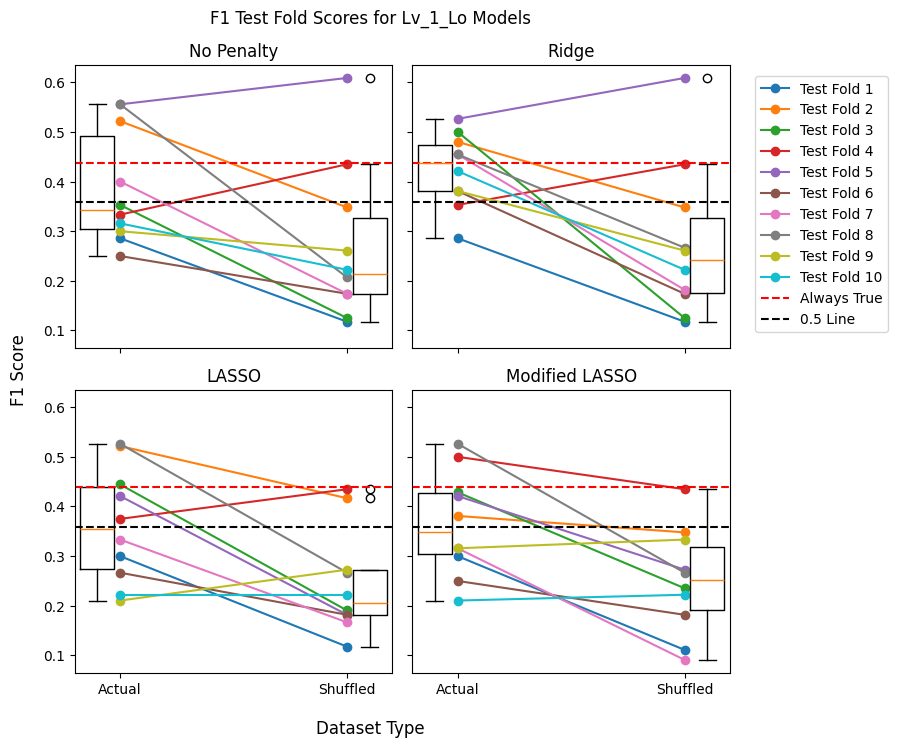

In [108]:
graph_folds(f1_scores, f1_scores_shuffled, predictors_df, outcomes_df, "Lv_1_Lo", "F1")

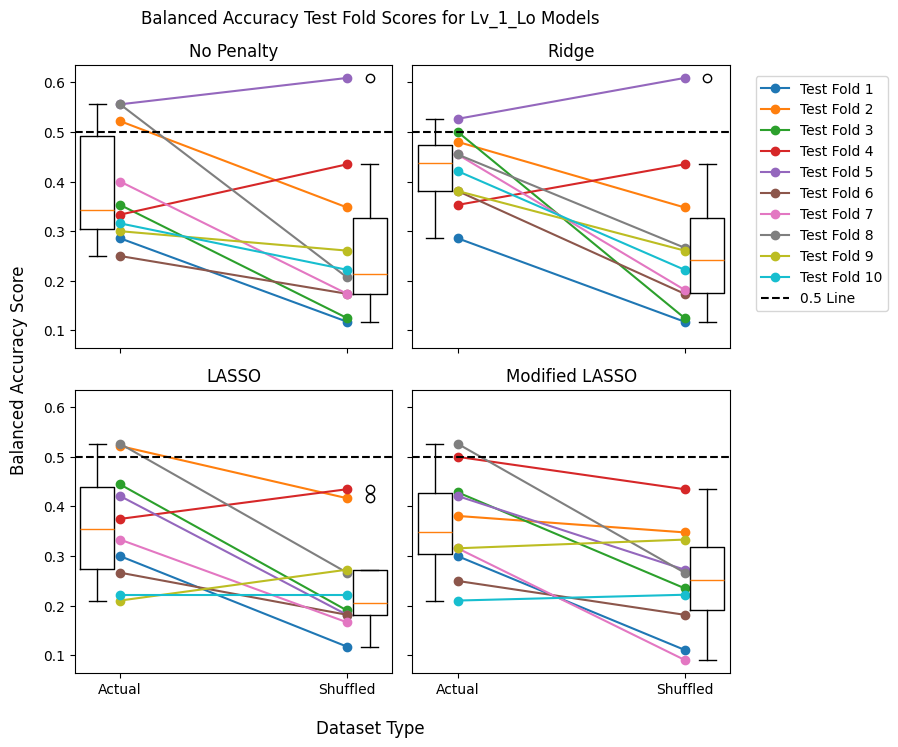

In [109]:
graph_folds(f1_scores, f1_scores_shuffled, predictors_df, outcomes_df, "Lv_1_Lo", "Balanced Accuracy")

In [9]:
# Get number of features
print("Actual Data")
for i in range(10):
    print(np.sum(CV_models["Lv_1_Lo"]["LASSO"][i].coef_[0] != 0), np.sum(CV_models["Lv_1_Lo"]["Modified LASSO"][i].coef_[0] != 0))

print()

print("Shuffled")
for i in range(10):
    print(np.sum(CV_models_shuffled["Lv_1_Lo"]["LASSO"][i].coef_[0] != 0), np.sum(CV_models_shuffled["Lv_1_Lo"]["Modified LASSO"][i].coef_[0] != 0))

Actual Data
5910 1914
5915 1870
5881 1845
4635 1876
1435 1128
117 114
5026 1889
123 122
131 126
97 94

Shuffled
4653 1836
1043 863
122 119
110 107
118 115
4659 1971
112 112
117 116
113 113
108 105


/home/jshen/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


0.6341463414634146 0.2857142857142857

0.717948717948718 0.5217391304347826

0.7555555555555555 0.35294117647058826

0.7272727272727273 0.3333333333333333

0.8181818181818182 0.5555555555555556

0.7391304347826086 0.25

0.7142857142857143 0.4

0.8181818181818182 0.5555555555555556

0.6666666666666666 0.3

0.6976744186046512 0.3157894736842105



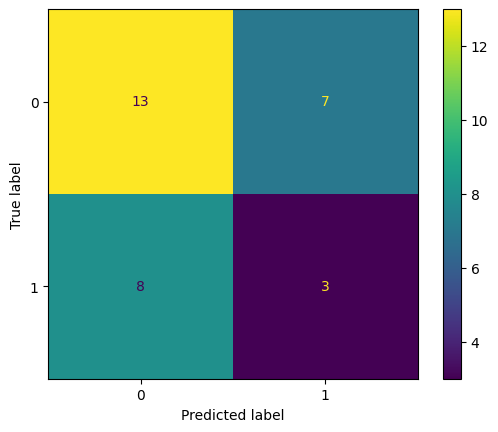

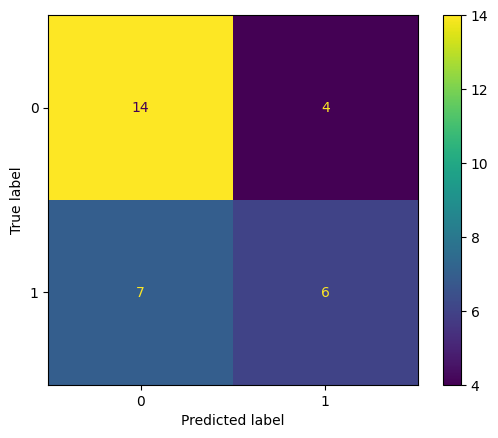

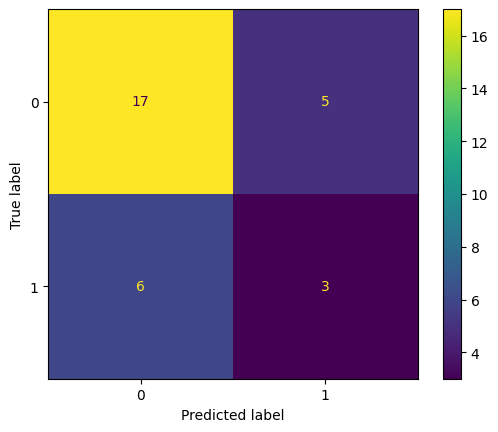

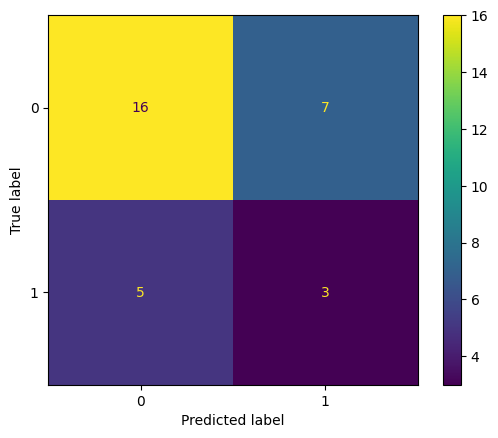

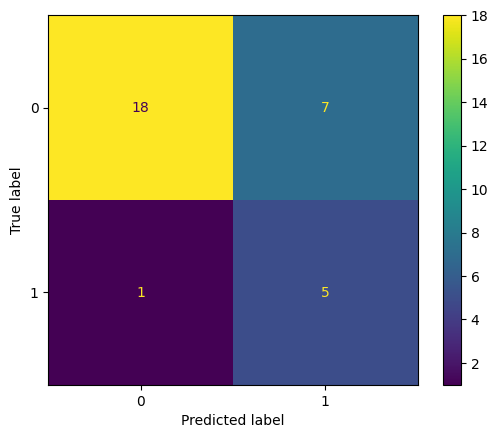

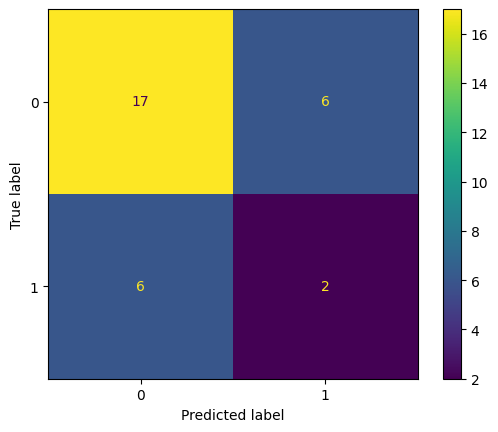

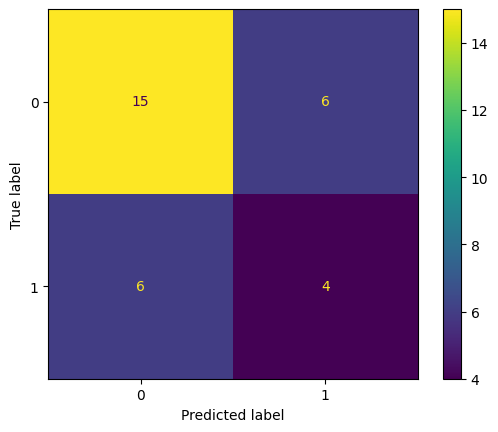

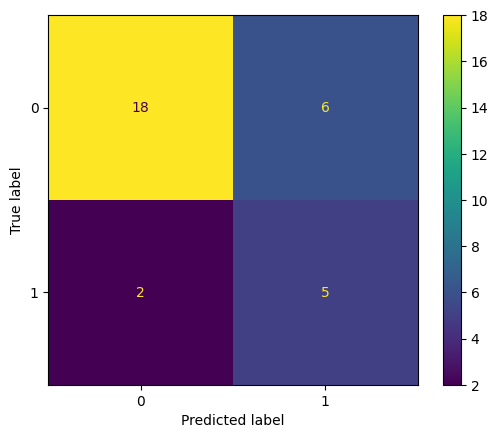

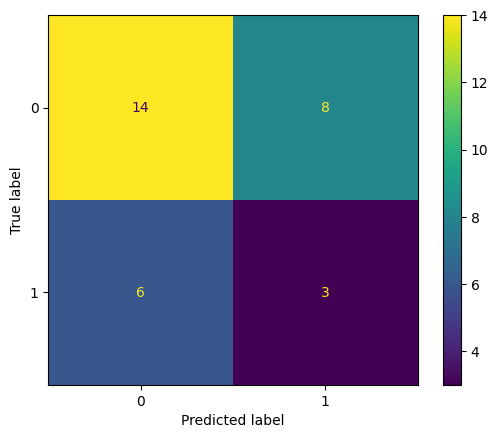

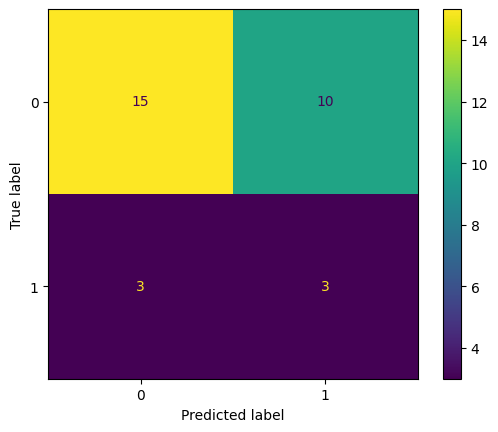

In [119]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
a = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
for i, (CV_idx, test_idx) in enumerate(a.split(predictors_df, ids)):
    # Train-Test Split for the Fold
    ids_CV = ids.iloc[CV_idx].values
    # ids_test = ids.iloc[test_idx].values
    # trial_nums_CV = ids.iloc[CV_idx].values
    # trial_nums_test = ids.iloc[test_idx].values
    pred_CV = predictors_df.iloc[CV_idx, :].values
    pred_test = predictors_df.iloc[test_idx, :].values
    out_CV = outcomes_df.iloc[CV_idx, 4].values
    out_test = outcomes_df.iloc[test_idx, 4].values

    # Standardize data for each test fold
    scaler = StandardScaler()
    pred_CV = scaler.fit_transform(pred_CV)
    pred_test = scaler.transform(pred_test)

    # print(np.array(out_test))
    # print(1 - np.array(out_test))
    # print()
    # print(f1_score(1 - np.array(out_test), 1 - np.array(CV_models["Lv_1_Lo"]["No Penalty"][i].predict(pred_test))))

    print(classification_report(out_test, CV_models["Lv_1_Lo"]["No Penalty"][i].predict(pred_test), output_dict = True)["0"]["f1-score"], classification_report(out_test, CV_models["Lv_1_Lo"]["No Penalty"][i].predict(pred_test), output_dict = True)["1"]["f1-score"])
    ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(out_test, CV_models["Lv_1_Lo"]["No Penalty"][i].predict(pred_test)), display_labels = [0, 1]).plot()
    print()

    # print(CV_models["Lv_1_Lo"]["Ridge"][i].predict(pred_test))

    # probs = CV_models["Lv_1_Lo"]["Ridge"][i].predict_proba(pred_test)[:, 1]
    # precision, recall, thresholds = precision_recall_curve(out_test, probs)
    # f1_scores = 2 * (precision * recall) / (precision + recall)
    # best_threshold = thresholds[np.argmax(f1_scores)]

    # print(best_threshold, f1_score(out_test, (probs >= best_threshold).astype(int)))